In [1]:
!pip install --upgrade kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.13
    Uninstalling kagglehub-0.3.13:
      Successfully uninstalled kagglehub-0.3.13


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kwentar/blur-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'blur-dataset' dataset.
Path to dataset files: /kaggle/input/blur-dataset


In [3]:
import os

def show_dataset_structure(root_path):
    print(" Dataset Structure:\n")
    for folder in sorted(os.listdir(root_path)):
        folder_path = os.path.join(root_path, folder)
        if os.path.isdir(folder_path):
            images = os.listdir(folder_path)
            print(f"{folder}")
            print(f"   Number of images: {len(images)}")
            print(f"   Sample images: {images[:3]}\n")

show_dataset_structure(path)

 Dataset Structure:

blur_dataset_scaled
   Number of images: 3
   Sample images: ['defocused_blurred', 'sharp', 'motion_blurred']

defocused_blurred
   Number of images: 350
   Sample images: ['0_IPHONE-SE_F.JPG', '330_XIAOMI-PROCOFONE-F1_F.jpg', '46_IPHONE-8-PLUS_F.jpg']

motion_blurred
   Number of images: 350
   Sample images: ['191_NIKON-D3400-18-55MM_M.JPG', '343_XIAOMI-PROCOFONE-F1_M.jpg', '278_HONOR-7X_M.jpg']

sharp
   Number of images: 350
   Sample images: ['186_HONOR-8_S.jpg', '125_NIKON-D3400-35MM_S.JPG', '155_HONOR-10_S.jpg']



In [4]:
import cv2
import numpy as np
import os
import pandas as pd

def extract_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()

    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    tenengrad = np.mean(gx**2 + gy**2)

    return laplacian_var, tenengrad
data = []

for label in ["sharp", "motion_blurred", "defocused_blurred"]:
    folder_path = os.path.join(path, label)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        features = extract_features(img_path)

        if features is not None:
            data.append([img_name, label, features[0], features[1]])

df = pd.DataFrame(
    data,
    columns=["image_name", "label", "laplacian_var", "tenengrad"]
)

df.head()


,image_name,label,laplacian_var,tenengrad
0,186_HONOR-8_S.jpg,sharp,303.262079,2491.120179
1,125_NIKON-D3400-35MM_S.JPG,sharp,4692.356157,2884.914597
2,155_HONOR-10_S.jpg,sharp,739.631595,6641.108629
3,299_NIKON-D3400-35MM_S.JPG,sharp,1633.610618,9758.703626
4,32_HUAWEI-P-SMART_S.jpg,sharp,200.937266,2590.039721


In [5]:
import os
import cv2
import numpy as np
import pandas as pd

# المسار الصحيح لمجلد الصور
dataset_folder = "/kaggle/input/blur-dataset/blur_dataset_scaled"
blur_types = ['sharp', 'defocused_blurred', 'motion_blurred']

# إنشاء DataFrame فارغ
df = pd.DataFrame(columns=['image_name', 'blur_type', 'laplacian', 'grad_var', 'sobel_mag', 'tenengrad'])

# دوال الميزات الأربعة
def laplacian_var(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

def gradient_var(img):
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    mag = np.sqrt(gx**2 + gy**2)
    return mag.var()

def sobel_mag(img):
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    return np.mean(np.sqrt(gx**2 + gy**2))

def tenengrad(img):
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    return np.sum(gx**2 + gy**2)

# قراءة الصور وحساب الميزات
rows = []
for blur_type in blur_types:
    folder = os.path.join(dataset_folder, blur_type)
    if not os.path.exists(folder):
        print(f"{blur_type} folder not found!")
        continue
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        lap = laplacian_var(img)
        grad = gradient_var(img)
        sob = sobel_mag(img)
        ten = tenengrad(img)
        rows.append([img_name, blur_type, lap, grad, sob, ten])

df = pd.DataFrame(rows, columns=['image_name', 'blur_type', 'laplacian', 'grad_var', 'sobel_mag', 'tenengrad'])

# عرض النتائج
print(df.head())
print("\nعدد الصور لكل نوع:")
print(df['blur_type'].value_counts())
print("\nأحصائية لكل ميزة:")
print(df[['laplacian','grad_var','sobel_mag','tenengrad']].describe())

                   image_name blur_type    laplacian     grad_var  sobel_mag  \
0           186_HONOR-8_S.jpg     sharp   303.262079  1426.688132  32.625635   
1  125_NIKON-D3400-35MM_S.JPG     sharp  4692.356157  1573.526123  36.213098   
2          155_HONOR-10_S.jpg     sharp   739.631595  5642.127633  31.606661   
3  299_NIKON-D3400-35MM_S.JPG     sharp  1633.610618  8383.289701  37.086573   
4     32_HUAWEI-P-SMART_S.jpg     sharp   200.937266  2095.543740  22.237266   

      tenengrad  
0  7.836386e+09  
1  8.064836e+09  
2  2.089112e+10  
3  2.728065e+10  
4  8.147560e+09  

عدد الصور لكل نوع:
blur_type
sharp                350
defocused_blurred    350
motion_blurred       350
Name: count, dtype: int64

أحصائية لكل ميزة:
          laplacian      grad_var    sobel_mag     tenengrad
count   1050.000000   1050.000000  1050.000000  1.050000e+03
mean     287.446112   1612.533906    22.090647  7.256369e+09
std      691.780354   3313.182756    18.552681  1.626489e+10
min        1.7883

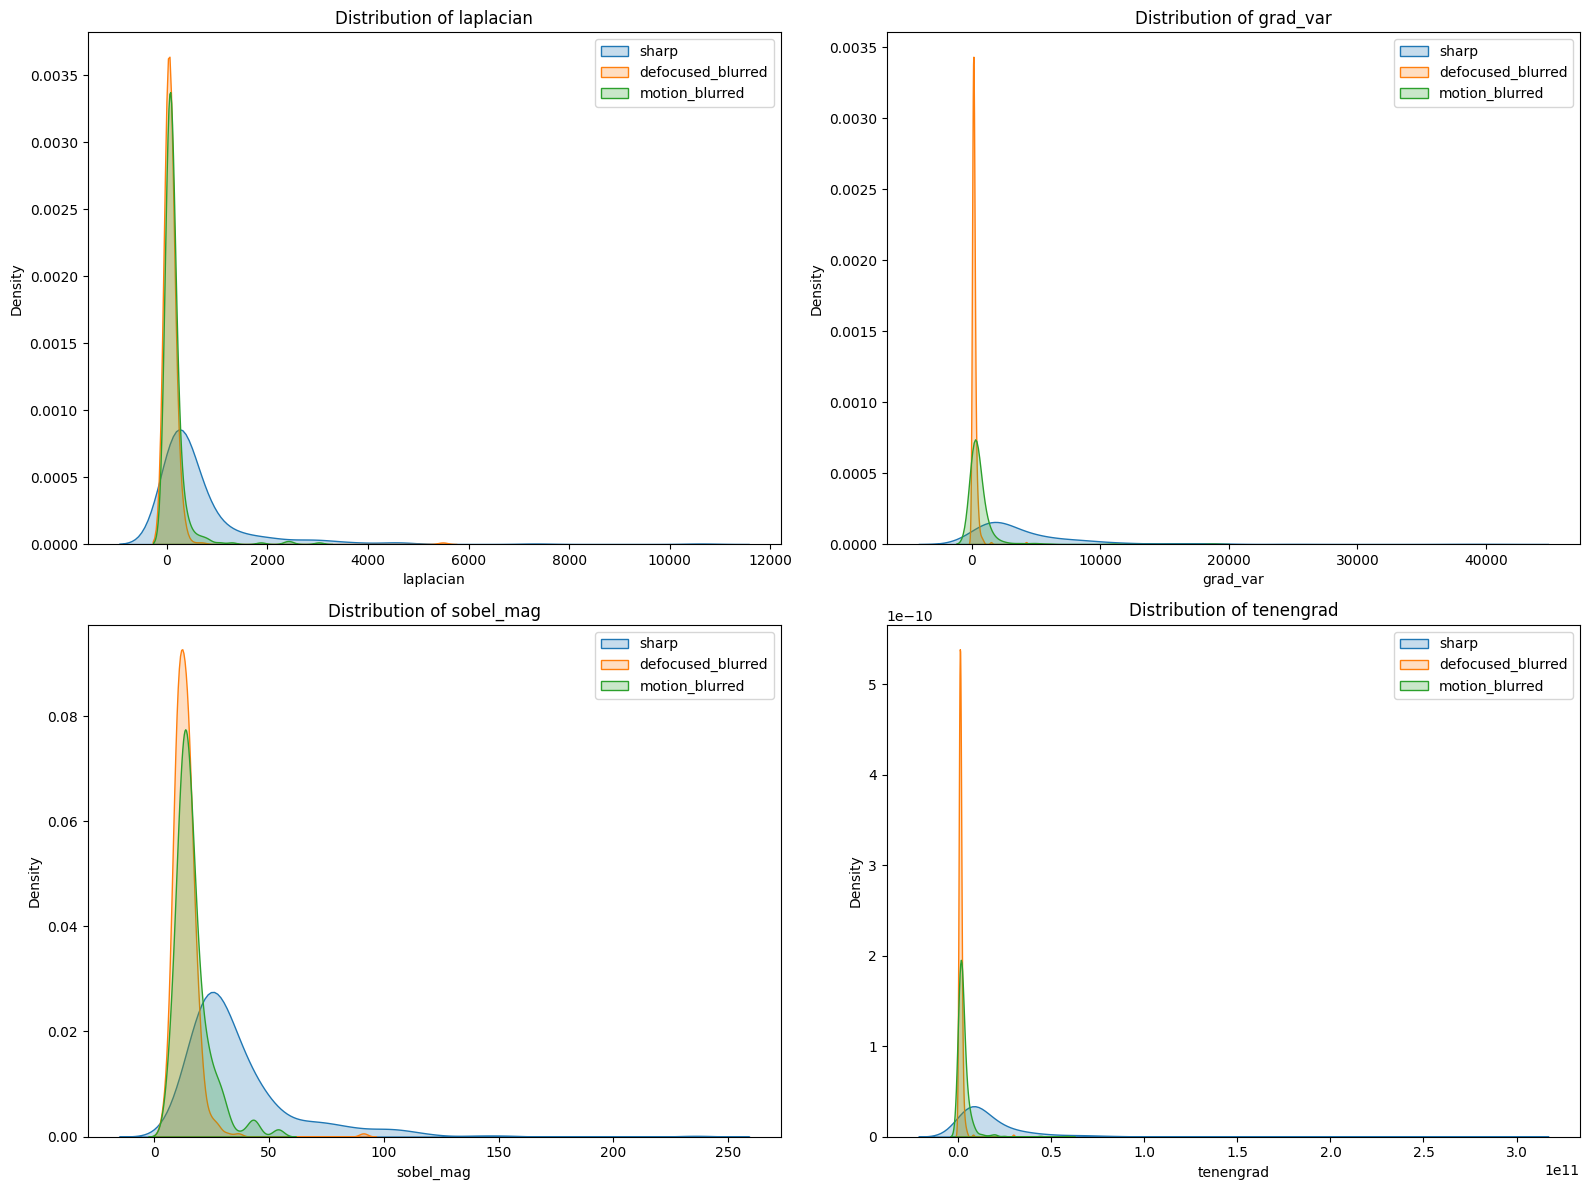

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# اختيار الميزات الأربع
features = ['laplacian', 'grad_var', 'sobel_mag', 'tenengrad']

plt.figure(figsize=(16,12))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    for blur_type in df['blur_type'].unique():
        sns.kdeplot(df[df['blur_type']==blur_type][feature], label=blur_type, fill=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()

 Accuracy: 0.8905
 Confusion Matrix:
 [[ 55  15]
 [  8 132]]


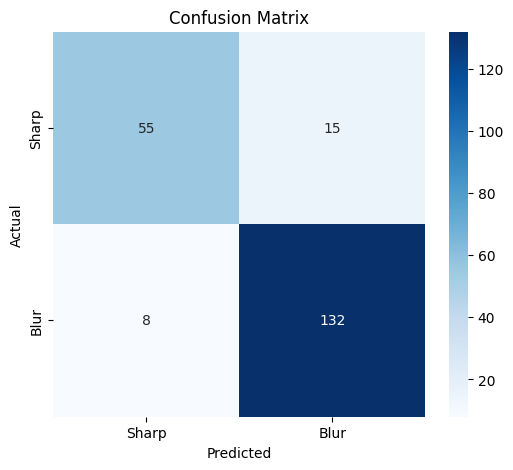

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 4 features
features = ['laplacian', 'grad_var', 'sobel_mag', 'tenengrad']

# sharp=0, blur=1
df['label'] = df['blur_type'].apply(lambda x: 0 if x == 'sharp' else 1)

X = df[features].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(20,), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)

y_pred = mlp.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(" Accuracy:", round(acc, 4))
print(" Confusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sharp', 'Blur'],
            yticklabels=['Sharp', 'Blur'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [8]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["Sharp", "Blur"]))


              precision    recall  f1-score   support

       Sharp       0.87      0.79      0.83        70
        Blur       0.90      0.94      0.92       140

    accuracy                           0.89       210
   macro avg       0.89      0.86      0.87       210
weighted avg       0.89      0.89      0.89       210



In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix

# نعمل prediction لكل البيانات
X_all = df[features].values
y_all = df['label'].values

X_all_scaled = scaler.transform(X_all)
y_all_pred = mlp.predict(X_all_scaled)

df['predicted'] = y_all_pred

subtypes = ['sharp', 'motion_blurred', 'defocused_blurred']

for subtype in subtypes:
    sub_df = df[df['blur_type'] == subtype]

    y_true = sub_df['label'].values
    y_pred_sub = sub_df['predicted'].values

    acc = accuracy_score(y_true, y_pred_sub)
    cm = confusion_matrix(y_true, y_pred_sub)

    print(f"\n--- {subtype} ---")
    print("Accuracy:", round(acc, 4))
    print("Confusion Matrix:\n", cm)



--- sharp ---
Accuracy: 0.8086
Confusion Matrix:
 [[283  67]
 [  0   0]]

--- motion_blurred ---
Accuracy: 0.8829
Confusion Matrix:
 [[  0   0]
 [ 41 309]]

--- defocused_blurred ---
Accuracy: 0.9943
Confusion Matrix:
 [[  0   0]
 [  2 348]]


In [14]:
# حفظ DataFrame كملف CSV
df.to_csv('blur_features_results.csv', index=False)


In [15]:
from google.colab import files

files.download('blur_features_results.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>